In [1]:
import pandas as pd
import numpy as np
from scipy import stats as st
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
data = pd.read_csv('/content/drive/MyDrive/Data_set/DroughtPredictionData/CDR_198301_202204.csv', index_col=0)
data.head(5)

,Rain(mm)
Time,
Jan-83,19.867
Feb-83,34.360
Mar-83,60.145
Apr-83,149.032
May-83,49.682


In [4]:
#Standardized Precipitation Index Function
def spi(ds, thresh):
    #ds - data ; thresh - time interval / scale
    
    #Rolling Mean / Moving Averages
    ds_ma = ds.rolling(thresh, center=False).mean()
    
    #Natural log of moving averages
    ds_In = np.log(ds_ma)
    ds_In[ np.isinf(ds_In) == True] = np.nan  #Change infinity to NaN
    
    #Overall Mean of Moving Averages
    ds_mu = np.nanmean(ds_ma)
    
    #Summation of Natural log of moving averages
    ds_sum = np.nansum(ds_In)
        
    #Computing essentials for gamma distribution
    n = len(ds_In[thresh-1:])                  #size of data
    A = np.log(ds_mu) - (ds_sum/n)             #Computing A
    alpha = (1/(4*A))*(1+(1+((4*A)/3))**0.5)   #Computing alpha  (a)
    beta = ds_mu/alpha                         #Computing beta (scale)
    
    #Gamma Distribution (CDF)
    gamma = st.gamma.cdf(ds_ma, a=alpha, scale=beta)  
    
    #Standardized Precipitation Index   (Inverse of CDF)
    norm_spi = st.norm.ppf(gamma, loc=0, scale=1)  #loc is mean and scale is standard dev.
    
    return ds_ma, ds_In, ds_mu, ds_sum, n, A, alpha, beta, gamma, norm_spi

In [5]:
times = [6,9,12]
for i in times:
    x = spi(data[' Rain(mm)'], i)
    data['spi_'+str(i)] = x[9]

In [6]:

data.replace([np.inf, -np.inf], np.nan, inplace=True)
data = data.dropna()

In [7]:
data

,Rain(mm),spi_6,spi_9,spi_12
Time,,,,
Dec-83,4.114,0.467211,0.689314,0.478341
Jan-84,3.585,-0.263333,-0.146764,0.390099
Feb-84,30.056,-1.654311,-0.274497,0.366527
Mar-84,43.443,-1.871739,-0.017003,0.274039
Apr-84,38.383,-1.336448,-0.509543,-0.384990
...,...,...,...,...
21-Dec,0.000,0.006743,-0.183300,-0.761327
22-Jan,26.900,-1.737797,-0.233915,-0.603866
22-Feb,0.800,-2.834041,-0.589738,-0.601492


In [ ]:
data

,Rain(mm),spi_6,spi_9,spi_12
Time,,,,
Dec-83,4.114,0.467211,0.689314,0.478341
Jan-84,3.585,-0.263333,-0.146764,0.390099
Feb-84,30.056,-1.654311,-0.274497,0.366527
Mar-84,43.443,-1.871739,-0.017003,0.274039
Apr-84,38.383,-1.336448,-0.509543,-0.384990
...,...,...,...,...
21-Dec,0.000,0.006743,-0.183300,-0.761327
22-Jan,26.900,-1.737797,-0.233915,-0.603866
22-Feb,0.800,-2.834041,-0.589738,-0.601492


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: Passing the minor parameter of set_yticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  


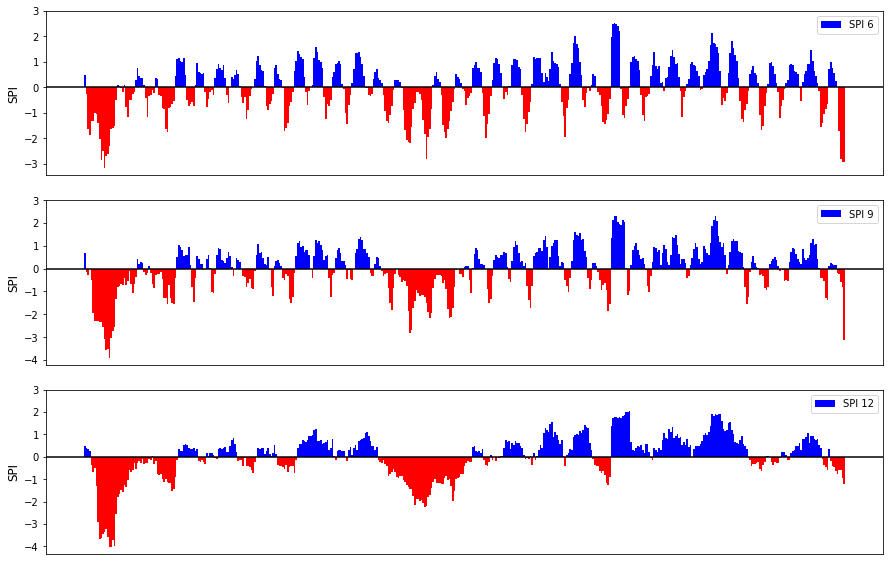

In [8]:
fig, axes = plt.subplots(nrows=3, figsize=(15, 10))
plt.subplots_adjust(hspace=0.15)
for i, ax in enumerate(axes):
    col_scheme=np.where(data['spi_'+str(times[i])]>0, 'b','r')
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    ax.bar(data.index, data['spi_'+str(times[i])], width=1, align='center', color=col_scheme, label='SPI '+str(times[i]))
    ax.axhline(y=0, color='k')
    ax.xaxis.set_major_locator(mdates.YearLocator(3))
    ax.legend(loc='upper right')
    ax.set_yticks(range(-3,4), range(-3,4))
    ax.set_ylabel('SPI', fontsize=12)
    
    if i<len(times)-1:
        ax.set_xticks([],[])

In [9]:
import tensorflow as tf
from tensorflow import keras
from keras.models import load_model
from keras import Sequential
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from keras.layers import Dense

In [10]:

print(data['spi_6'].max())
print(data['spi_9'].max())
print(data['spi_12'].max())


2.532842370624761
2.3110281408006363
2.0448851035129465


In [11]:

print(data['spi_6'].min())
print(data['spi_9'].min())
print(data['spi_12'].min())


-3.17594862526538
-3.9027288091536643
-4.052220481049848


In [24]:
def create_dataset2(dataframe, sliding_window=1):

    dataset = dataframe
    dataX, dataY = [], []
    for i in range(0,len(dataset)-sliding_window-1,2):
        a = dataset[i:(i+sliding_window), :]
        dataX.append(a)
        b = dataset[(i+sliding_window):(i+sliding_window)+2,:]
        dataY.append(b)
    return np.array(dataX), np.array(dataY)

In [25]:

# split into train and test sets
data2 = data['spi_12']
dataset = data2.values
dataset = np.reshape(dataset,(len(dataset),1))
#from sklearn.preprocessing import MinMaxScaler
#scaler  = MinMaxScaler(feature_range=(0, 1))
#dataset = scaler.fit_transform(dataset)
train_size  = int(len(dataset) * 0.70)
test_size   = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train), len(test))



322 139


In [26]:
slide_window   = 12
trainX, trainY = create_dataset2(train, slide_window)
testX, testY   = create_dataset2(test, slide_window)

In [27]:
trainX = np.reshape(trainX, (trainX.shape[0], slide_window, 1))
testX  = np.reshape(testX , (testX.shape[0] , slide_window, 1))

In [31]:
model = tf.keras.models.load_model('/content/drive/MyDrive/Model/Drought_Models/SPI_12.h5')

In [32]:
trainPredict = model.predict(trainX)
testPredict  = model.predict(testX)
 
 

In [33]:
testPredict.shape

(63, 2, 1)

In [34]:
Actual = np.reshape(testY, (len(testY)*2,1))
Predicted = np.reshape(testPredict, (len(testPredict)*2,1))

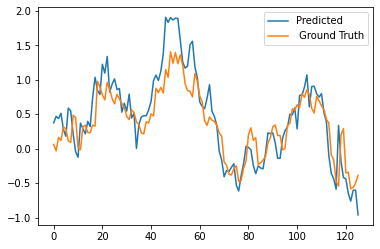

In [35]:
plt.plot(Actual[:,0],label='Predicted')
plt.plot(Predicted[:,0],label= ' Ground Truth')
plt.legend()

In [36]:
import math

MSE = np.square(np.subtract(Actual,Predicted)).mean() 
 
RMSE = math.sqrt(MSE)
print("Root Mean Square Error:\n")
print(RMSE)

Root Mean Square Error:

0.31866023193637927


In [39]:
ac  = pd.DataFrame(Actual[-122:], columns = ['SPI_12_Actual'])
pred = pd.DataFrame(Predicted[-122:], columns = ['SPI_12_Predicted'])
dates = np.array(data.index[-123:-1])
dat = pd.DataFrame(dates, columns= ['Dates'])
Test_Data = pd.concat([dat,ac,pred], ignore_index=True, axis=1)
Test_Data = Test_Data.rename({0: 'Time', 1: 'Actual' , 2: 'Predicted'}, axis='columns') 
Test_Data = Test_Data.set_index('Time')

In [ ]:
Test_Data

,Actual,Predicted
Time,,
12-Feb,0.279695,0.404026
12-Mar,0.181058,0.259034
12-Apr,0.589787,0.185925
12-May,0.548807,0.460790
12-Jun,0.213318,0.481735
...,...,...
21-Nov,-0.649629,-0.340936
21-Dec,-0.761327,-0.513478
22-Jan,-0.603866,-0.634742


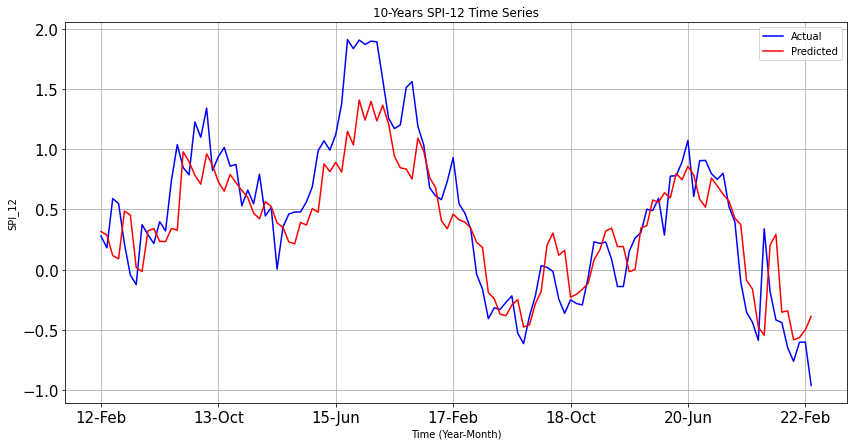

In [40]:

Test_Data.plot(kind='line',xlabel='Time (Year-Month)', ylabel= 'SPI_12',grid=True,figsize=(14,7),title='10-Years SPI-12 Time Series',
               color= {'Actual':'blue','Predicted':"red"},fontsize=15,backend='matplotlib')

# Testing April-May-June Predictions

In [42]:
Jan = test[-15:-3]
Feb =  test[-14:-2]
March    = test[-13:-1]
April  = test[-12:]

In [43]:
March_Test = np.reshape(March, (1,12,1))
April_Test = np.reshape(April, (1,12,1)) 
Jan_Test = np.reshape(Jan, (1,12,1)) 
Feb_Test = np.reshape(Feb, (1,12,1)) 

In [44]:
March_Pred = model.predict(March_Test) 
April_Pred = model.predict(April_Test)
Jan_Pred = model.predict(Jan_Test)
Feb_Pred = model.predict(Feb_Test)


In [45]:
March_Test

array([[[-0.3555412 ],
        [-0.43730708],
        [-0.58746502],
        [ 0.33873868],
        [-0.18207661],
        [-0.41828218],
        [-0.43942635],
        [-0.64962853],
        [-0.7613275 ],
        [-0.60386582],
        [-0.60149171],
        [-0.96215247]]])

In [46]:
print("April Predicted SPI {}".format(March_Pred[0][0]))
print("May Predicted SPI {}".format(March_Pred[0][1]))

April Predicted SPI [-0.9043398]
May Predicted SPI [-0.8671544]


In [47]:
print("May Predicted SPI {}".format(April_Pred[0][0]))
print("June Predicted SPI {}".format(April_Pred[0][1]))

May Predicted SPI [-1.1433222]
June Predicted SPI [-1.0888703]


In [48]:
print("March Predicted SPI {}".format(Feb_Pred[0][0]))
print("April Predicted SPI {}".format(Feb_Pred[0][1]))

March Predicted SPI [-0.50424266]
April Predicted SPI [-0.40042287]


In [49]:
print("Feb Predicted SPI {}".format(Jan_Pred[0][0]))
print("March Predicted SPI {}".format(Jan_Pred[0][1]))

Feb Predicted SPI [-0.4995257]
March Predicted SPI [-0.3876669]


In [ ]:
Actual[-12:]

array([[-1.06106909],
       [-0.85060281],
       [-0.6695378 ],
       [ 0.72196802],
       [ 1.00343433],
       [ 0.74756456],
       [ 0.56080588],
       [ 0.24372956],
       [ 0.0067428 ],
       [-1.73779724],
       [-2.83404138],
       [-2.92053298]])

In [ ]:
data.to_excel('Time_SPI.xlsx')

In [ ]:
figure, axes = plt.subplots(3, 1)
data['spi_6'].plot(ax=axes[0],figsize=(20,12), sharex=True,sharey=True ,legend=True )
data['spi_9'].plot(ax=axes[1],legend=True)
data['spi_12'].plot(ax=axes[2],legend=True)

In [ ]:
data2[-20:
      ]

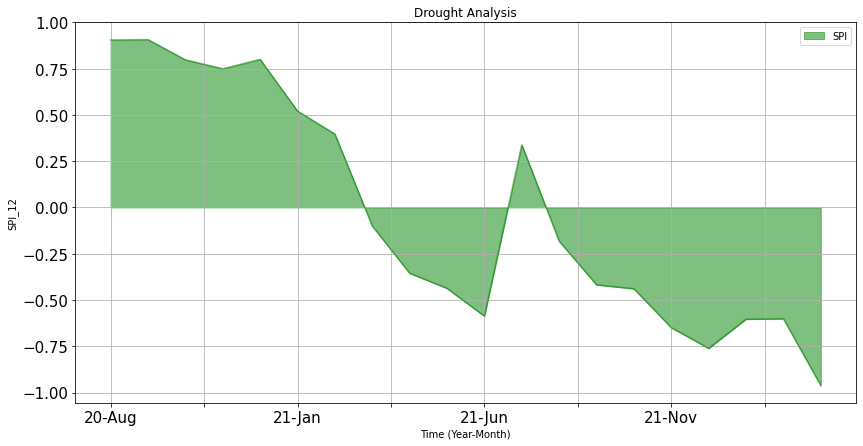

In [ ]:
ac  = pd.DataFrame(Actual[-20:], columns = ['SPI_12_Actual'])
#pred = pd.DataFrame(Predicted[-20:], columns = ['SPI_12_Predicted'])

dates = np.array(data.index[-21:-1])
dat = pd.DataFrame(dates, columns= ['Dates'])
Test_Data = pd.concat([dat,ac], ignore_index=True, axis=1)
Test_Data = Test_Data.rename({0: 'Time', 1: 'SPI'}, axis='columns') 
Test_Data = Test_Data.set_index('Time')



col_scheme=np.where(Test_Data['SPI'] < 0, 'b','g')
Test_Data.plot.area(xlabel='Time (Year-Month)', ylabel= 'SPI_12',grid=True,figsize=(14,7),title='Drought Analysis',color=col_scheme,fontsize=15,backend='matplotlib',stacked=False)

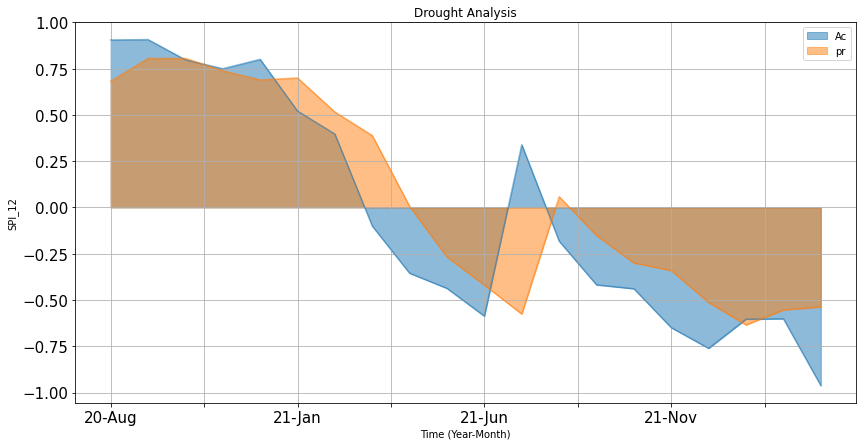

In [ ]:
ac  = pd.DataFrame(Actual[-20:], columns = ['SPI_12_Actual'])
pred = pd.DataFrame(Predicted[-20:], columns = ['SPI_12_Predicted'])

dates2 = np.array(data.index[-21:-1])
dat2 = pd.DataFrame(dates2, columns= ['Dates'])
Test_Data2 = pd.concat([dat2,ac,pred], ignore_index=True, axis=1)
Test_Data2 = Test_Data2.rename({0: 'Time', 1: 'Ac', 2 : 'pr'}, axis='columns') 
Test_Data2 = Test_Data2.set_index('Time')



col_scheme=np.where(Test_Data['SPI'] < 0, 'b','g')
Test_Data2.plot.area(xlabel='Time (Year-Month)', ylabel= 'SPI_12',grid=True,figsize=(14,7),title='Drought Analysis',fontsize=15,backend='matplotlib',stacked=False)


In [ ]:
Test_Data2

,SPI
Time,
20-Aug,0.764217
20-Sep,1.129522
20-Oct,0.710635
20-Nov,0.133458
20-Dec,-0.147938
21-Jan,-0.253839
21-Feb,-0.327263
21-Mar,-1.220131
21-Apr,-1.042179
